# Hypotheses
- Incoming weights will become more distributed (less sparse) across input features
- The magnitude of weight vectors will increase to accommodate multiple feature representations
- The angular distance between weight vectors of different neurons will decrease as they begin to capture overlapping concepts



## Dataset

In [97]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

class MonoToPolySemanticsDataset(Dataset):
    """
    Dataset for the mono-to-poly semantics experiment.

    Phase 1: Classification based only on orientation (vertical vs. horizontal lines)
    Phase 2: Classification based on orientation AND color combinations
    """

    def __init__(self,
                 num_samples=5000,
                 img_size=32,
                 phase=1,
                 save_dir='dataset_images',
                 seed=42):
        """
        Initialize the dataset.

        Args:
            num_samples (int): Number of samples to generate
            img_size (int): Size of the square images
            phase (int): Training phase (1 or 2)
            save_dir (str): Directory to save generated images (if None, images are not saved)
            seed (int): Random seed for reproducibility
        """
        self.num_samples = num_samples
        self.img_size = img_size
        self.phase = phase
        self.seed = seed
        self.save_dir = save_dir

        # Set random seed for reproducibility
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)

        # Create directory to save images if specified
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Generate the dataset
        self.data, self.labels, self.metadata = self._generate_dataset()

    def _generate_line_image(self, orientation, color):
        """
        Generate an image with a line of specified orientation and color.

        Args:
            orientation (str): 'vertical' or 'horizontal'
            color (str): 'red' or 'blue'

        Returns:
            numpy.ndarray: RGB image as a numpy array
        """
        # Create blank image (white background)
        img = np.ones((self.img_size, self.img_size, 3), dtype=np.float32)

        # Get color values
        if color == 'red':
            color_val = np.array([1.0, 0.0, 0.0])  # RGB for red
        else:  # blue
            color_val = np.array([0.0, 0.0, 1.0])  # RGB for blue

        # Draw line
        line_width = max(1, self.img_size // 8)  # Line is 1/8 of the image size
        center = self.img_size // 2

        if orientation == 'vertical':
            start_x = center - line_width // 2
            end_x = center + line_width // 2
            for x in range(start_x, end_x):
                img[0:self.img_size, x] = color_val
        else:  # horizontal
            start_y = center - line_width // 2
            end_y = center + line_width // 2
            for y in range(start_y, end_y):
                img[y, 0:self.img_size] = color_val

        # Add some noise to make it more challenging
        noise = np.random.normal(0, 0.05, img.shape)
        img = np.clip(img + noise, 0, 1)

        return img

    def _generate_dataset(self):
        """
        Generate the full dataset based on the phase.

        Returns:
            tuple: (data, labels, metadata)
                data: torch tensor of shape (num_samples, 3, img_size, img_size)
                labels: torch tensor of shape (num_samples, 2)
                metadata: list of dicts with 'orientation' and 'color' for each sample
        """
        data = []
        labels = []
        metadata = []

        orientations = ['vertical', 'horizontal']
        colors = ['red', 'blue']

        for i in range(self.num_samples):
            # Randomly select orientation and color
            orientation = orientations[np.random.randint(0, 2)]
            color = colors[np.random.randint(0, 2)]

            # Generate image
            img = self._generate_line_image(orientation, color)

            # Convert to tensor format (C, H, W)
            img_tensor = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)

            # Determine label based on phase
            if self.phase == 1:
                # Phase 1: Only orientation matters
                label = torch.tensor([1.0, 0.0] if orientation == 'vertical' else [0.0, 1.0],
                                   dtype=torch.float32)
            else:  # Phase 2
                # Phase 2: Combination of orientation and color
                is_class1 = (orientation == 'vertical' and color == 'red') or \
                            (orientation == 'horizontal' and color == 'blue')
                label = torch.tensor([1.0, 0.0] if is_class1 else [0.0, 1.0],
                                   dtype=torch.float32)

            data.append(img_tensor)
            labels.append(label)
            metadata.append({'orientation': orientation, 'color': color})

            # Save image if directory is specified
            if self.save_dir:
                img_save = (img * 255).astype(np.uint8)
                img_pil = Image.fromarray(img_save)
                img_name = f"{i}_{orientation}_{color}.png"
                img_pil.save(os.path.join(self.save_dir, img_name))

        # Stack all data and labels
        data = torch.stack(data)
        labels = torch.stack(labels)

        return data, labels, metadata

    def __len__(self):
        """Return the size of the dataset."""
        return self.num_samples

    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        return self.data[idx], self.labels[idx]

    def get_metadata(self, idx):
        """Get metadata for a sample."""
        return self.metadata[idx]

    def switch_to_phase(self, phase):
        """Switch the dataset to a different phase."""
        if phase != self.phase:
            self.phase = phase
            # Regenerate labels based on new phase
            new_labels = []
            for meta in self.metadata:
                orientation = meta['orientation']
                color = meta['color']

                if phase == 1:
                    # Phase 1: Only orientation matters
                    label = torch.tensor([1.0, 0.0] if orientation == 'vertical' else [0.0, 1.0],
                                       dtype=torch.float32)
                else:  # Phase 2
                    # Phase 2: Combination of orientation and color
                    is_class1 = (orientation == 'vertical' and color == 'red') or \
                                (orientation == 'horizontal' and color == 'blue')
                    label = torch.tensor([1.0, 0.0] if is_class1 else [0.0, 1.0],
                                       dtype=torch.float32)

                new_labels.append(label)

            self.labels = torch.stack(new_labels)
            print(f"Dataset switched to Phase {phase}")

    def visualize_samples(self, num_samples=5):
        """Visualize random samples from the dataset with their labels."""
        indices = np.random.choice(len(self), num_samples, replace=False)

        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))

        for i, idx in enumerate(indices):
            img = self.data[idx].numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
            label = self.labels[idx].numpy()
            meta = self.metadata[idx]

            axes[i].imshow(img)

            if self.phase == 1:
                label_text = f"Orientation: {meta['orientation']}\nLabel: {'Vertical' if label[0] > 0.5 else 'Horizontal'}"
            else:
                is_class1 = label[0] > 0.5
                label_text = f"O: {meta['orientation']}, C: {meta['color']}\nLabel: {'Class 1' if is_class1 else 'Class 2'}"

            axes[i].set_title(label_text, fontsize=10)
            axes[i].axis('off')

        plt.tight_layout()
        return fig

Dataset switched to Phase 2
Batch shape: torch.Size([32, 3, 32, 32])
Target shape: torch.Size([32, 2])


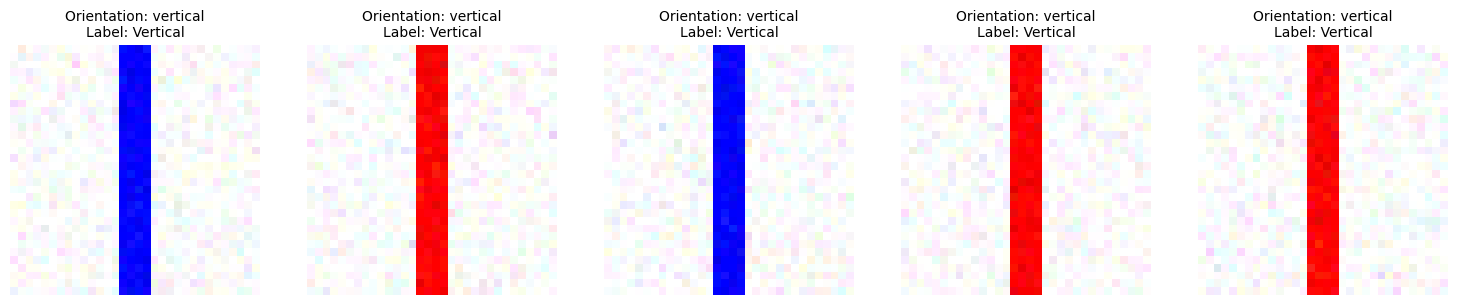

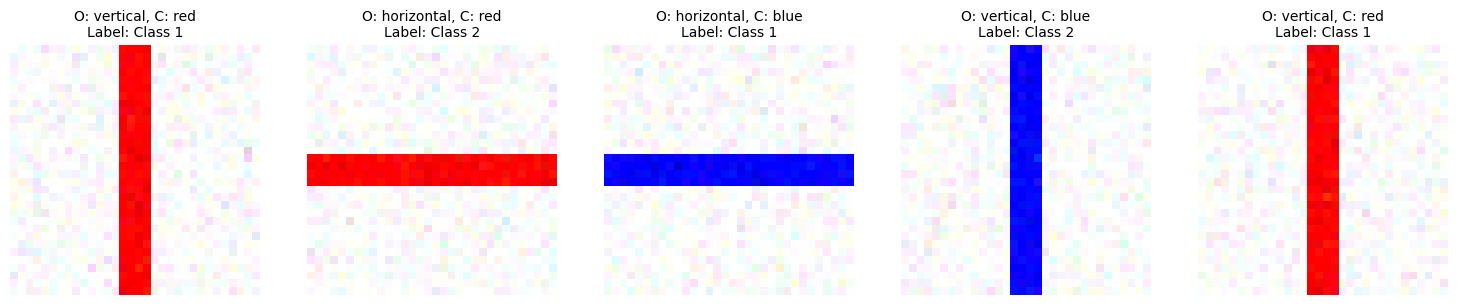

In [98]:
  # Create Phase 1 dataset
  dataset_phase1 = MonoToPolySemanticsDataset(num_samples=1000, phase=1)

  # Visualize some samples
  fig = dataset_phase1.visualize_samples(5)
  plt.savefig("phase1_samples.png")

  # Switch to Phase 2
  dataset_phase1.switch_to_phase(2)

  # Visualize the same samples with Phase 2 labels
  fig = dataset_phase1.visualize_samples(5)
  plt.savefig("phase2_samples.png")

  # Create data loaders for training
  train_loader = DataLoader(dataset_phase1, batch_size=32, shuffle=True)

  # Example of iterating through the data loader
  for batch_idx, (data, target) in enumerate(train_loader):
      if batch_idx == 0:
          print(f"Batch shape: {data.shape}")
          print(f"Target shape: {target.shape}")
          break

## Model

In [99]:
import torch.nn as nn

class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NNModel, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight) #well-balanced weight distribution
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

        self.activation_cache = []


    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)

        Returns:
            tuple: (output, hidden_activations)
                output: Model output
                hidden_activations: Activations of the hidden layer
        """
        # Flatten the input
        x = x.view(x.size(0), -1)

        # Hidden layer with ReLU activation
        hidden = self.fc1(x)
        hidden_activations = self.relu(hidden)

        #self.training is a boolean attribute to track these things
        if not self.training:
            self.activation_cache.append(hidden_activations.detach().cpu().numpy())

        # Output layer
        output = self.fc2(hidden_activations)

        return output, hidden_activations

    def get_weights(self):
        """
        Get the weights of the model.

        Returns:
            tuple: (fc1_weights, fc2_weights)
                fc1_weights: Weights of the first fully connected layer
                fc2_weights: Weights of the second fully connected layer
        """
        return self.fc1.weight.data.cpu().numpy(), self.fc2.weight.data.cpu().numpy()



## Train Model

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from typing import Dict, List

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    phase: int,
    epochs: int = 50,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    analyzer: WeightDynamicsAnalyzer = WeightDynamicsAnalyzer()
) -> List[Dict]:
    """
    Basic training loop with validation.

    Args:
        model: Neural network model
        train_loader: Training data loader
        val_loader: Validation data loader
        phase: Training phase (1 or 2)
        epochs: Number of training epochs
        device: Device to run training on

    Returns:
        List of dictionaries containing training statistics per epoch
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    stats = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            # Convert to class indices for consistent format
            preds = outputs.argmax(dim=1).cpu().numpy()
            target_indices = torch.argmax(targets, dim=1).cpu().numpy()
            train_preds.extend(preds)
            train_targets.extend(target_indices)

        # Validation
        val_loss, val_preds, val_targets, test_activations = test_model(model, val_loader, criterion, device)

        # Record statistics
        epoch_stats = {
            'phase': phase,
            'epoch': epoch + 1,
            'train_loss': train_loss / len(train_loader),
            'train_acc': accuracy_score(train_targets, train_preds),
            'val_loss': val_loss / len(val_loader),
            'val_acc': accuracy_score(val_targets, val_preds)
        }
        stats.append(epoch_stats)

        with torch.no_grad():
            metrics = analyzer.analyze_epoch(
              model=model,
              epoch=epoch,
              activations=test_activations,
              phase='phase1'  # or 'phase2'
            )

        if (epoch + 1) % 10 == 0:
            print(f'Phase {phase}, Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {epoch_stats["train_loss"]:.4f}, Train Acc: {epoch_stats["train_acc"]:.4f}')
            print(f'Val Loss: {epoch_stats["val_loss"]:.4f}, Val Acc: {epoch_stats["val_acc"]:.4f}')

    return stats

def test_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: str
) -> tuple:
    """
    Test the model and return loss and predictions.
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, hidden = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            # Convert to class indices for consistent format
            preds = outputs.argmax(dim=1).cpu().numpy()
            target_indices = torch.argmax(targets, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(target_indices)

    return total_loss, all_preds, all_targets, hidden

### Run Training

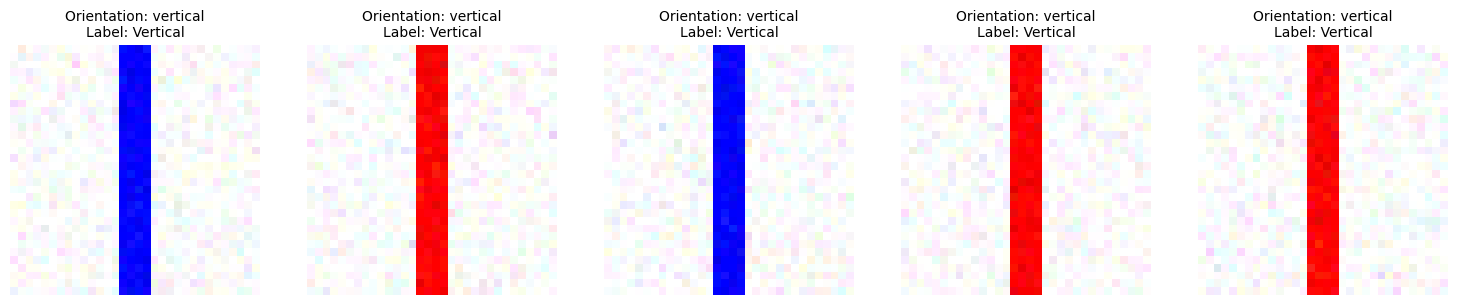

In [101]:
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from typing import Dict, List
import os

train_split = 0.8
batch_size = 32

dataset = MonoToPolySemanticsDataset(num_samples=1000, phase=1)

# Split dataset into train and validation
train_size = int(train_split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

fig = dataset.visualize_samples(5)

In [102]:
analyzer = WeightDynamicsAnalyzer()
model = NNModel(input_dim=3*32*32, hidden_dim=20, output_dim=2)
phase1_stats = train_model(model, train_loader, val_loader, phase=1, analyzer=analyzer)

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [ ]:
stats_df = pd.DataFrame(phase1_stats)
stats_df.to_csv('phase1_stats.csv', index=False)

## Analysis

In [ ]:
def get_neuron_acts(model, test_loader: DataLoader) -> torch.Tensor:
    """
    Calculate concept selectivity for each neuron.

    Args:
        test_loader: DataLoader for test data

    Returns:
        Tensor containing selectivity scores (hidden_dim,)
    """
    model.eval()
    category_activations = {}

    with torch.no_grad():
        # Initialize as {neuron_idx: {category: [activations]}}
        neuron_activations = {i: {} for i in range(model.hidden_dim)}

        for data, labels in test_loader:
            data = data.to(model.device)
            _, activations = model(data)  # activations shape: [batch_size, num_neurons]

            # For each sample in batch
            for i, label in enumerate(labels):
                category = label.item()
                # For each neuron
                for neuron_idx in range(model.hidden_dim):
                    if category not in neuron_activations[neuron_idx]:
                        neuron_activations[neuron_idx][category] = []
                    # Add this activation value for this neuron for this category
                    neuron_activations[neuron_idx][category].append(activations[i, neuron_idx].cpu().numpy())

    # Now neuron_activations[0][1] gives you all activations of neuron 0 for category 1
    # You can verify the length matches your dataset:
    print(f"Neuron 0, Category 1 has {len(neuron_activations[0][1])} activation values")

    # output should be the full data
    return neuron_activations

In [ ]:
def calculate_semanticity(neuron_acts):
    """
    Calculate neuron semanticity using entropy.
    Lower entropy = more monosemantic (concentrated activations)
    Higher entropy = more polysemantic (distributed activations)

    Args:
        neuron_acts: Dict[neuron_idx: Dict[category: List[activations]]]
    Returns:
        Dict[neuron_idx: float]: entropy scores (0-1, higher means more monosemantic)
    """
    scores = {}

    for neuron_idx, categories in neuron_acts.items():
        # Get mean activation per category
        avgs = np.array([np.mean(acts) for acts in categories.values()])

        # Convert to probability distribution (normalize)
        probs = avgs / np.sum(avgs)

        # Calculate entropy and normalize it to 0-1 range
        # max_entropy is log2(n_categories)
        max_entropy = np.log2(len(categories))
        entropy = -np.sum(probs * np.log2(probs + 1e-10))  # add small epsilon to avoid log(0)

        # Convert to semanticity score (1 - normalized entropy)
        # 1.0 = perfectly monosemantic
        # 0.0 = perfectly polysemantic
        scores[neuron_idx] = 1 - (entropy / max_entropy)

    return scores

In [ ]:
import numpy as np
import torch
from scipy.stats import entropy
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional

class WeightDynamicsAnalyzer:
    """
    Analyzes and tracks neural network weight dynamics during mono-to-poly semantic transitions.

    Key metrics tracked:
    1. Weight Distribution (Entropy)
    2. Weight Magnitude (L2 norm)
    3. Angular Distance between neurons
    4. Concept Response Selectivity (CRS)
    """

    def __init__(self, save_dir: str = 'results'):
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)

        # Initialize storage for metrics
        self.metrics = {
            'phase1': {
                'weight_entropy': [],
                'weight_magnitude': [],
                'angular_distances': [],
                'selectivity_scores': [],
                'category_activations': [],
                'epoch': []
            },
            'phase2': {
                'weight_entropy': [],
                'weight_magnitude': [],
                'angular_distances': [],
                'selectivity_scores': [],
                'category_activations': [],
                'epoch': []
            }
        }

        # Keep track of current phase
        self.current_phase = 'phase1'

    def analyze_epoch(self,
                     model: torch.nn.Module,
                     epoch: int,
                     activations: torch.Tensor,
                     phase: Optional[str] = None) -> Dict:
        """
        Analyze network weights and activations after each epoch.

        Args:
            model: The neural network model
            epoch: Current epoch number
            activations: Hidden layer activations for the test set
            phase: Current training phase ('phase1' or 'phase2')

        Returns:
            Dictionary containing computed metrics for the current epoch
        """
        if phase:
            self.current_phase = phase

        # Get model weights
        fc1_weights, _ = model.get_weights()

        # Compute metrics
        entropy_scores = self._compute_weight_entropy(fc1_weights)
        magnitudes = self._compute_weight_magnitude(fc1_weights)
        angular_dists = self._compute_angular_distances(fc1_weights)
        selectivity_scores = self._compute_selectivity(activations)

        # Store metrics
        current_metrics = {
            'weight_entropy': entropy_scores,
            'weight_magnitude': magnitudes,
            'angular_distances': angular_dists,
            'selectivity_scores': selectivity_scores,
            'epoch': epoch
        }

        # Update storage
        for key, value in current_metrics.items():
            self.metrics[self.current_phase][key].append(value)

        return current_metrics

    def _compute_weight_entropy(self, weights: np.ndarray) -> np.ndarray:
        """
        Compute entropy of weight distributions for each neuron.
        Higher entropy indicates more distributed weights.
        """
        # Normalize weights to get probability-like distributions
        weights_norm = np.abs(weights) / np.sum(np.abs(weights), axis=1, keepdims=True)
        return np.array([entropy(w) for w in weights_norm])

    def _compute_weight_magnitude(self, weights: np.ndarray) -> np.ndarray:
        """Calculate L2 norm of weight vectors for each neuron."""
        return np.linalg.norm(weights, axis=1)

    def _compute_angular_distances(self, weights: np.ndarray) -> float:
        """
        Compute mean angular distance between all pairs of weight vectors.
        """
        # Normalize weights
        weights_norm = weights / np.linalg.norm(weights, axis=1, keepdims=True)

        # Compute cosine similarities
        cos_sims = np.dot(weights_norm, weights_norm.T)

        # Convert to angles in degrees
        angles = np.arccos(np.clip(cos_sims, -1.0, 1.0)) * 180.0 / np.pi

        # Return mean of upper triangle (excluding diagonal)
        return np.mean(angles[np.triu_indices_from(angles, k=1)])

    def _compute_selectivity(self, activations: np.ndarray) -> Tuple[Dict[int, float], Dict[int, Dict[str, float]]]:
        """
        Calculate selectivity for each neuron based on category responses.
        A neuron is monosemantic if its average activation for one category
        is significantly higher than other categories.

        Args:
            activations: Array of shape (n_samples, n_neurons) containing neuron activations

        Returns:
            Tuple containing:
                - Dict mapping neuron index to selectivity score
                - Dict mapping neuron index to dict of category averages
        """
        neuron_acts = {}

        # Organize activations by neuron and category
        for neuron_idx in range(activations.shape[1]):
            if self.current_phase == 'phase1':
                categories = {
                    'vertical': activations[::2, neuron_idx],
                    'horizontal': activations[1::2, neuron_idx]
                }
            else:  # phase2
                categories = {
                    'vertical_red': activations[0::4, neuron_idx],
                    'vertical_blue': activations[1::4, neuron_idx],
                    'horizontal_red': activations[2::4, neuron_idx],
                    'horizontal_blue': activations[3::4, neuron_idx]
                }
            neuron_acts[neuron_idx] = categories

        # Calculate selectivity using the provided function
        neuron_selectivity = calculate_semanticity(neuron_acts)

        return [neuron_selectivity[idx] for idx in sorted(scores.keys())]



    def generate_visualizations(self):
        """
        Generate and save visualizations of tracked metrics.
        """
        self._plot_metric_evolution('weight_entropy', 'Weight Distribution Entropy')
        self._plot_metric_evolution('weight_magnitude', 'Weight Vector Magnitude')
        self._plot_metric_evolution('angular_distances', 'Mean Angular Distance')
        self._plot_metric_evolution('crs_scores', 'Semanticity')
        self._plot_phase_comparison()

    def _plot_metric_evolution(self, metric_name: str, title: str):
        """Plot evolution of a metric over training epochs."""
        if metric_name == 'category_activations':
            self._plot_category_activations()
            return

        plt.figure(figsize=(10, 6))

        # Plot Phase 1
        phase1_data = np.array(self.metrics['phase1'][metric_name])
        epochs = self.metrics['phase1']['epoch']

        # Handle dictionary data type for selectivity scores
        if isinstance(phase1_data[0], dict):
            phase1_data = np.array([[d[i] for d in phase1_data] for i in range(len(phase1_data[0]))])

        plt.plot(epochs, np.mean(phase1_data, axis=1), label='Phase 1', color='blue')

        # Plot Phase 2 if exists
        if len(self.metrics['phase2'][metric_name]) > 0:
            phase2_data = np.array(self.metrics['phase2'][metric_name])
            epochs = self.metrics['phase2']['epoch']

            if isinstance(phase2_data[0], dict):
                phase2_data = np.array([[d[i] for d in phase2_data] for i in range(len(phase2_data[0]))])

            plt.plot(epochs, np.mean(phase2_data, axis=1), label='Phase 2', color='red')

        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.replace('_', ' ').title())
        plt.legend()
        plt.savefig(self.save_dir / f'{metric_name}_evolution.png')
        plt.close()

    def _plot_category_activations(self):
        """Create detailed plots of category-specific activations for each phase."""
        for phase in ['phase1', 'phase2']:
            if not self.metrics[phase]['category_activations']:
                continue

            # Get the last epoch's category activations
            latest_activations = self.metrics[phase]['category_activations'][-1]

            # Create a subplot for each neuron
            n_neurons = len(latest_activations)
            fig, axes = plt.subplots(1, n_neurons, figsize=(4*n_neurons, 4))
            if n_neurons == 1:
                axes = [axes]

            for neuron_idx, ax in enumerate(axes):
                neuron_data = latest_activations[neuron_idx]
                categories = list(neuron_data.keys())
                values = list(neuron_data.values())

                ax.bar(range(len(categories)), values)
                ax.set_xticks(range(len(categories)))
                ax.set_xticklabels(categories, rotation=45)
                ax.set_title(f'Neuron {neuron_idx}')

            plt.suptitle(f'{phase} Category Activations')
            plt.tight_layout()
            plt.savefig(self.save_dir / f'{phase}_category_activations.png')
            plt.close()

    def _plot_phase_comparison(self):
        """Generate violin plots comparing distributions between phases."""
        metrics_to_plot = ['weight_entropy', 'weight_magnitude', 'crs_scores']

        fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(15, 5))

        for i, metric in enumerate(metrics_to_plot):
            data = {
                'Phase 1': np.array(self.metrics['phase1'][metric]).flatten(),
                'Phase 2': np.array(self.metrics['phase2'][metric]).flatten()
            }

            df = pd.DataFrame({
                'Phase': np.repeat(['Phase 1', 'Phase 2'],
                                 [len(data['Phase 1']), len(data['Phase 2'])]),
                'Value': np.concatenate([data['Phase 1'], data['Phase 2']])
            })

            sns.violinplot(data=df, x='Phase', y='Value', ax=axes[i])
            axes[i].set_title(metric.replace('_', ' ').title())

        plt.tight_layout()
        plt.savefig(self.save_dir / 'phase_comparison.png')
        plt.close()

    def save_metrics(self):
        """Save all metrics to CSV files."""
        for phase in ['phase1', 'phase2']:
            df = pd.DataFrame(self.metrics[phase])
            df.to_csv(self.save_dir / f'{phase}_metrics.csv', index=False)

    def load_metrics(self, path: str):
        """Load previously saved metrics."""
        for phase in ['phase1', 'phase2']:
            df = pd.read_csv(Path(path) / f'{phase}_metrics.csv')
            self.metrics[phase] = df.to_dict('list')